In [10]:
import re
import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset

import numpy as np
import pandas as pd

from skimage.transform import resize

from sklearn.model_selection import train_test_split

DATA_DIR_ROOT_MAIN = "/projects/bk_pca/BK_UBC_CORES/"
DATA_DIR_PATCH_ROOT =  "/ssd005/projects/exactvu_pca/bk_ubc/patches/UBC/patch_48x48_str32_avg/"

def get_patch_labels():
    patients = {}
    for patient in os.listdir(DATA_DIR_PATCH_ROOT):
        labels = []
        invs = []
        patient_id = patient.replace("Patient", "")
        try:
            for core in os.listdir(DATA_DIR_PATCH_ROOT + str(patient) + "/patches_rf_core"):
                labels.append(1 if "cancer" in core else 0)
                inv = re.findall('_inv([\d.[0-9]+)', core)
                invs.append(float(inv[0]) if inv else 0)
            patients[patient_id] = (labels, invs)
        except FileNotFoundError:
            continue
    return patients

def build_label_table():
    df = pd.DataFrame()
    for key, value in get_patch_labels().items():
        labels, invs = value
        for i in range(len(labels)):
            label, inv = labels[i], invs[i]
            row = pd.DataFrame({"core_id": [f'{key}.{i}'], "patient_id": [key], "label": [label], "inv": [inv]})
            df = pd.concat([df, row], ignore_index=True)
    return df

def select_patients(all_files, patient_ids):
    patient_files = []
    for file in all_files:
        patient = int(re.findall('/Patient(\d+)/', file)[0])
        if patient in patient_ids:
            patient_files.append(file)
    return patient_files

def get_tmi23_patients(inv_threshold=None):
    def _format_patient_list(lst):
        return [f"{pid}" for pid in lst]
    table = build_label_table()
    if inv_threshold:
        table = table[(table["inv"] >= inv_threshold) | (table["label"] == 0)]

    train_pa = _format_patient_list([2, 3, 5, 6, 8, 11, 13, 14, 15, 16, 18, 20, 22, 23, 24, 26, 27, 28, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 68, 69, 70, 71, 72, 74, 76, 78, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100])
    val_pa = _format_patient_list([130, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 117, 121, 123, 124, 125, 126, 127])
    test_pa = _format_patient_list([131, 132, 133, 134, 136, 138, 139, 141, 142, 143, 144, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 175, 176, 181, 182, 186, 187])

    train_idx = table.patient_id.isin(set(train_pa))
    val_idx = table.patient_id.isin(val_pa)
    test_idx = table.patient_id.isin(test_pa)

    train_tab, val_tab, test_tab = table[train_idx], table[val_idx], table[test_idx]

    assert set(train_tab.patient_id) & set(val_tab.patient_id) == set()
    assert set(train_tab.patient_id) & set(test_tab.patient_id) == set()
    assert set(val_tab.patient_id) & set(test_tab.patient_id) == set()

    return train_tab, val_tab, test_tab

def split_patients(inv_threshold=None, by_patients=None):
    table = build_label_table(by_patients)
    if inv_threshold:
        table = table[(table["inv"] >= inv_threshold) | (table["label"] == 0)]
    patient_table = table.drop_duplicates(subset=["patient_id"])

    train_pa, val_pa = train_test_split(patient_table, 
        test_size=0.3, random_state=0, 
        stratify=patient_table["label"])
    
    val_pa, test_pa = train_test_split(val_pa, 
        test_size=0.5, random_state=0, 
        stratify=val_pa["label"])

    train_idx = table.patient_id.isin(train_pa.patient_id)
    val_idx = table.patient_id.isin(val_pa.patient_id)
    test_idx = table.patient_id.isin(test_pa.patient_id)
    
    train_tab, val_tab, test_tab = table[train_idx], table[val_idx], table[test_idx]

    assert set(train_tab.patient_id) & set(val_tab.patient_id) == set()
    assert set(train_tab.patient_id) & set(test_tab.patient_id) == set()
    assert set(val_tab.patient_id) & set(test_tab.patient_id) == set()

    return train_tab, val_tab, test_tab

def make_bk_dataloaders(self_supervised=False):
    train_tab, val_tab, test_tab = get_tmi23_patients()

    _BKPatchesDataset = BKPatchLabeledDataset if not self_supervised else BKPatchUnlabeledDataset
    transform =PatchTransform() if not self_supervised else PatchSSLTransform()
    train_ds = _BKPatchesDataset(DATA_DIR_PATCH_ROOT, patient_ids=train_tab.patient_id, transform=transform)
    val_ds = _BKPatchesDataset(DATA_DIR_PATCH_ROOT, patient_ids=val_tab.patient_id, transform=transform)
    test_ds = _BKPatchesDataset(DATA_DIR_PATCH_ROOT, patient_ids=test_tab.patient_id, transform=transform)

    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

    return train_dl, val_dl, test_dl

def make_corewise_bk_dataloaders(batch_sz, im_sz=1024):
    train_tab, val_tab, test_tab = get_tmi23_patients()

    transform = CorewiseTransform()
    train_ds = BKCorewiseDataset(DATA_DIR_ROOT_MAIN, df=train_tab, transform=transform, im_sz=im_sz)
    val_ds = BKCorewiseDataset(DATA_DIR_ROOT_MAIN, df=val_tab, transform=transform, im_sz=im_sz)
    test_ds = BKCorewiseDataset(DATA_DIR_ROOT_MAIN, df=test_tab, transform=transform, im_sz=im_sz)

    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_sz, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_sz, shuffle=False)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_sz, shuffle=False)

    return train_dl, val_dl, test_dl

class BKCorewiseDataset(Dataset):
    def __init__(self, data_dir, df, transform, im_sz=1024):
        super(BKCorewiseDataset, self).__init__()
        self.data = self.collect_files(df, data_dir)
        self.transform = transform
        self.table = df
        self.im_sz = im_sz

    def __getitem__(self, idx, style='last_frame'):
        file_arr = self.data[idx]
        roi_mask = np.load(file_arr[1])
        prostate_mask = np.load(file_arr[2])
        label = file_arr[3]
        involvement = file_arr[4]
        core_id = file_arr[5]
        patient_id = file_arr[6]
        rf_file = np.load(file_arr[0])

        if style == 'last_frame':
            bmode = self.make_analytical(rf_file[:, :, -1])
        elif style == 'avg_last_100':
            bmode = self.make_analytical(rf_file[:, :, -100:].mean(axis=-1))
        elif style == 'avg_all':
            bmode = self.make_analytical(rf_file.mean(axis=-1))
        elif style == 'random':
            frame_idx = np.random.randint(0, rf_file.shape[-1])
            bmode = self.make_analytical(rf_file[:, :, frame_idx])
        else:
            print("Invalid style. Using last frame.")
            bmode = self.make_analytical(rf_file[:, :, -1])
        
        bmode = resize(bmode, (self.im_sz, self.im_sz))
        roi_mask = resize(roi_mask, (self.im_sz // 4, self.im_sz // 4))
        prostate_mask = resize(prostate_mask, (self.im_sz // 4, self.im_sz // 4))

        return (bmode, roi_mask, prostate_mask, label, 
                involvement, core_id, patient_id)
    
    def __len__(self):
        return len(self.data)

    def collect_files(self, df, data_dir, core_idx_upper_bound=15):
        file_tuples = []
        for patient in list(set(df.patient_id)):
            for i in range(1, core_idx_upper_bound):
                try:
                    roi_file = (f'{data_dir}pat{patient}_cor{i}_needle.npy')
                    wp_file = (f'{data_dir}pat{patient}_cor{i}_prostate.npy')
                    rf_file = (f'{data_dir}pat{patient}_cor{i}_rf.npy')
                    os.stat(rf_file)
                    label_values = df[df.core_id == f'{patient}.{i}'].label.values
                    assert label_values.shape[0] == 1
                    sub_df = df[df.core_id == f'{patient}.{i}']
                    inv = sub_df.inv.values[0]
                    core_id = sub_df.core_id.values[0]
                    patient_id = sub_df.patient_id.values[0]
                    file_tuples.append((rf_file, roi_file, wp_file, label_values[0], inv, core_id, patient_id))
                except AssertionError:
                    pass
                except FileNotFoundError:
                    pass

        return file_tuples

    def make_analytical(self, x):
        from scipy.signal import hilbert
        return np.abs(hilbert(x)) ** 0.3

class BKPatchDataset(Dataset):
    def __init__(self, data_dir, patient_ids, transform, pid_range=(0, np.Inf), norm=True, return_idx=True, stats=None,
                 slide_idx=-1, time_series=False, pid_excluded=None, return_prob=False,
                 tta=False, *args, **kwargs):
        super(BKPatchDataset, self).__init__()
        # self.files = glob(f'{data_dir}/*/*/*/*.npy')
        data_dir = data_dir.replace('\\', '/')
        self.files = select_patients(glob(f'{data_dir}/*/patches_rf_core/*/*.npy'), patient_ids)
        self.transform = transform
        self.pid_range = pid_range
        self.pid_excluded = pid_excluded
        self.norm = norm
        self.pid, self.cid, self.inv, self.label = [], [], [], None
        self.attrs = ['files', 'pid', 'cid']
        self.stats = stats
        self.slide_idx = slide_idx
        self.time_series = time_series
        self.return_idx = return_idx
        self.return_prob = return_prob
        self.probability = None
        self.tta = tta  # test time augmentation

    def extract_metadata(self):
        for file in self.files:
            self.pid.append(int(re.findall('/Patient(\d+)/', file)[0]))
            self.cid.append(int(re.findall('/core(\d+)', file)[0]))
            self.inv.append(float(re.findall('_inv([\d.[0-9]+)', file)[0]))
        for attr in self.attrs:  # convert to array
            setattr(self, attr, np.array(getattr(self, attr)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx], mmap_mode='c').astype('float32')

        if self.transform is not None:
            data = self.transform(data)
        if self.time_series:
            data = F.avg_pool2d(torch.tensor(data), kernel_size=(8, 8), stride=8).flatten(1).T
            if self.norm:
                data = (data - np.median(data)) / (np.percentile(data, 75) - np.percentile(data, 25))
        if self.norm and not self.time_series:
            if isinstance(data, tuple) or isinstance(data, list):
                data = tuple(self.norm_data(d) for d in data)
            else:
                data = self.norm_data(data)
            data = (data - np.median(data)) / (np.percentile(data, 75) - np.percentile(data, 25))

        if self.tta:
            data = np.concatenate([data, np.flip(data, axis=-1)], axis=0)

        if self.label is not None:
            label = self.label[idx]
            if self.return_prob:
                assert self.probability is not None
                return data, label, self.probability[idx]
            if self.return_idx:
                return data, label, idx, self.pid[idx], self.cid[idx], self.inv[idx]
            return data, label

        return data[0], data[1]

    def norm_data(self, data):
        if self.stats is not None:
            data = (data - self.stats[0]) / self.stats[1]
        else:
            data = (data - data.mean()) / data.std()
        return data

    def filter_by_pid(self):
        idx = np.logical_and(self.pid >= self.pid_range[0], self.pid <= self.pid_range[1])
        if self.pid_excluded is not None:
            idx[np.isin(self.pid, self.pid_excluded)] = False
        self.filter_by_idx(idx)

    def filter_by_idx(self, idx):
        for attr in self.attrs:
            if getattr(self, attr) is not None:
                setattr(self, attr, getattr(self, attr)[idx])

class BKPatchLabeledDataset(BKPatchDataset):
    def __init__(self, data_dir, patient_ids, transform=None, pid_range=(0, np.Inf), inv_range=(0, 1), gs_range=(7, 10),
                 queens_data=False, file_idx=None, oversampling_cancer=False, *args, **kwargs):
        super().__init__(data_dir, patient_ids, transform, pid_range, *args, **kwargs)
        self.inv_range = inv_range
        self.gs_range = gs_range
        self.attrs.extend(['label', 'gs', 'location', 'id', 'inv'])
        self.label, self.inv, self.gs, self.location, self.id = [[] for _ in range(5)]
        self.queens_data = queens_data

        oversampling_dict = {0.8: 22, 0.7: 17, 0.6: 11, 0.5: 7, 0.4: 6}
        if oversampling_cancer:
            oversampling_rate = oversampling_dict[min(self.inv_range)]
            # the oversampling rate (17) is calculated based on the class ratio after all filtering steps
            oversampled_files = []
            for file in self.files:
                if '_cancer' in file:
                    oversampled_files.extend([file for _ in range(oversampling_rate)])
            self.files += oversampled_files

        self.extract_metadata()
        self.filter_by_pid()
        self.filter_by_inv()
        self.filter_by_gs()
        if file_idx is not None:
            self.filter_by_idx(file_idx)

    def extract_metadata(self):
        for file in self.files:
            folder_name = os.path.basename(os.path.dirname(file))
            self.label.append(0) if folder_name.split('_')[1] == 'benign' else self.label.append(1)
            self.location.append(folder_name.split('_')[-2])
            self.inv.append(float(re.findall('_inv([\d.[0-9]+)', file)[0]))
            self.gs.append(int(re.findall('_gs(\d+)', file)[0]))
            self.pid.append(int(re.findall('/Patient(\d+)/', file)[0]))
            self.cid.append(int(re.findall('/core(\d+)_', file)[0]))
            self.id.append(int(folder_name.split('_')[-1][2:]))
        for attr in self.attrs:  # convert to array
            setattr(self, attr, np.array(getattr(self, attr)))

    def filter_by_inv(self):
        idx = np.logical_and(self.inv >= self.inv_range[0], self.inv <= self.inv_range[1])
        idx = np.logical_or(idx, self.inv == 0)
        self.filter_by_idx(idx)

    def filter_by_gs(self):
        idx = np.logical_and(self.gs >= self.gs_range[0], self.gs <= self.gs_range[1])
        idx = np.logical_or(idx, self.gs == 0)
        self.filter_by_idx(idx)

class BKPatchUnlabeledDataset(BKPatchDataset):
    def __init__(self, data_dir, patient_ids, transform=None, pid_range=(0, np.Inf), stats=None, norm=True, *args, **kwargs):
        super(BKPatchUnlabeledDataset, self).__init__(data_dir, patient_ids, transform, pid_range, norm=norm)
        # Note: cid: per patient core id; id: absolute core id
        self.extract_metadata()
        self.filter_by_pid()

class PatchSSLTransform:
    def __call__(self, patch):
        patch = torch.from_numpy(patch).float() / 255.0
        patch = patch.unsqueeze(0).repeat_interleave(3, dim=0)

        augs = [
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        ]
        p1 = T.Compose(augs)(patch)
        p2 = T.Compose(augs)(patch)

        return p1, p2

class PatchTransform:
    def __call__(self, patch):
        patch = torch.from_numpy(patch).float() / 255.0
        patch = patch.unsqueeze(0).repeat_interleave(3, dim=0)
        return patch
    
class CorewiseTransform:
    def __call__(self, core):
        pass

In [11]:
def make_analytical(x):
    from scipy.signal import hilbert
    return np.abs(hilbert(x)) ** 0.3

In [12]:
train_tab, val_tab, test_tab = get_tmi23_patients()

In [13]:
train_tab

,core_id,patient_id,label,inv
0,81.0,81,0,0.0
1,81.1,81,1,0.9
2,81.2,81,1,0.5
3,81.3,81,0,0.0
4,81.4,81,0,0.0
...,...,...,...,...
942,27.8,27,0,0.0
943,65.0,65,0,0.0
944,65.1,65,0,0.0
945,65.2,65,0,0.0


(2344, 414, 200)


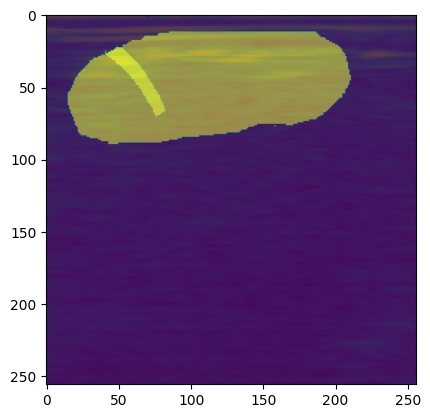

In [14]:
import matplotlib.pyplot as plt
from skimage.transform import resize

roi = np.load(f'{DATA_DIR_ROOT_MAIN}/pat81_cor1_needle.npy')
wp = np.load(f'{DATA_DIR_ROOT_MAIN}/pat81_cor1_prostate.npy')
core = np.load(f'{DATA_DIR_ROOT_MAIN}/pat81_cor1_rf.npy')
print(core.shape)

core = make_analytical(core[:, :, -1])
core = resize(core, (1024, 1024))
roi = resize(roi, (256, 256))
wp = resize(wp, (256, 256))

plt.imshow(core)
plt.imshow(roi, alpha=0.5)
plt.imshow(wp, alpha=0.5)
plt.show()

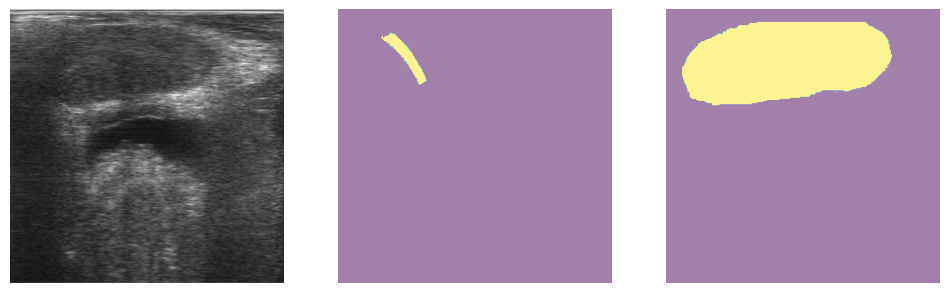

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
[ax.set_axis_off() for ax in ax.flatten()]
kwargs = dict(vmin=0, vmax=1, extent=(0, 46, 0, 28))

roi = np.load(f'{DATA_DIR_ROOT_MAIN}/pat81_cor1_needle.npy')
wp = np.load(f'{DATA_DIR_ROOT_MAIN}/pat81_cor1_prostate.npy')
core = np.load(f'{DATA_DIR_ROOT_MAIN}/pat81_cor1_rf.npy')

core = make_analytical(core[:, :, -1])
core = resize(core, (1024, 1024))
roi = resize(roi, (256, 256))
wp = resize(wp, (256, 256))

ax[0].imshow(core, cmap='gray')
ax[1].imshow(roi, alpha=0.5)
ax[2].imshow(wp, alpha=0.5)

pil_img = fig2img(fig)
pil_arr = np.array(pil_img).astype(np.float64)

#plt.imshow(pil_arr)

In [46]:
ax

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

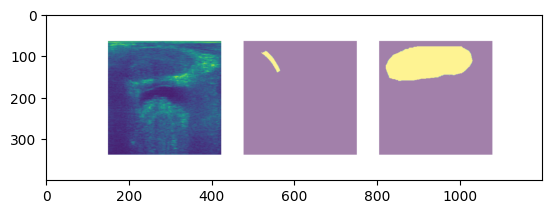

In [40]:
plt.imshow(pil_arr)

In [33]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    from PIL import Image
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [20]:
import wandb
wandb.Image(fig)

In [23]:
wandb.Image(fig)

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=0)
label_table = build_label_table()
train_tab, val_tab, test_tab = get_tmi23_patients()

In [23]:
train_tab.patient_id.unique().shape

(67,)

In [20]:
train_tab.groupby('patient_id').label.max()

patient_id
100    1
11     1
13     0
14     0
15     1
      ..
94     1
95     0
96     1
97     0
98     0
Name: label, Length: 67, dtype: int64

In [28]:
build_label_table()

,core_id,patient_id,label,inv
0,81.0,81,0,0.0
1,81.1,81,1,0.9
2,81.2,81,1,0.5
3,81.3,81,0,0.0
4,81.4,81,0,0.0
...,...,...,...,...
942,27.8,27,0,0.0
943,65.0,65,0,0.0
944,65.1,65,0,0.0
945,65.2,65,0,0.0


In [9]:
!ls /projects/bk_pca/BK_UBC_CORES/

pat100_cor0_info.json	    pat186_cor3_needle.npy
pat100_cor0_needle_bm.npy   pat186_cor3_prostate.npy
pat100_cor0_needle.npy	    pat186_cor3_rf.npy
pat100_cor0_prostate.npy    pat186_cor4_info.json
pat100_cor0_rf.npy	    pat186_cor4_needle_bm.npy
pat100_cor1_info.json	    pat186_cor4_needle.npy
pat100_cor1_needle_bm.npy   pat186_cor4_prostate.npy
pat100_cor1_needle.npy	    pat186_cor4_rf.npy
pat100_cor1_prostate.npy    pat186_cor5_info.json
pat100_cor1_rf.npy	    pat186_cor5_needle_bm.npy
pat100_cor2_info.json	    pat186_cor5_needle.npy
pat100_cor2_needle_bm.npy   pat186_cor5_prostate.npy
pat100_cor2_needle.npy	    pat186_cor5_rf.npy
pat100_cor2_prostate.npy    pat186_cor6_info.json
pat100_cor2_rf.npy	    pat186_cor6_needle_bm.npy
pat100_cor3_info.json	    pat186_cor6_needle.npy
pat100_cor3_needle_bm.npy   pat186_cor6_prostate.npy
pat100_cor3_needle.npy	    pat186_cor6_rf.npy
pat100_cor3_prostate.npy    pat187_cor10_info.json
pat100_cor3_rf.npy	    pat187_cor10_needle_bm.npy
pat100_cor

In [7]:
file_tuples = []
for patient in list(set(train_tab.patient_id)):
    patient_dir = f'{DATA_DIR_ROOT_MAIN}/npy/{patient}/'
    for i in range(1, 12):
        try:
            roi_file = (f'{patient_dir}Core{i}_roi.npy')
            wp_file = (f'{patient_dir}Core{i}_wp.npy')
            rf_file = (f'{patient_dir}Core{i}_rf_whole_200.npy')
            label_values = train_tab[train_tab.core_id == f'{patient}.{i}'].label.values
            assert label_values.shape[0] == 1
            file_tuples.append((roi_file, wp_file, rf_file, label_values[0]))
        except AssertionError:
            pass

In [8]:
train_tab, val_tab, test_tab = get_tmi23_patients()

In [9]:
p11_core9_roi = np.load(f'{DATA_DIR_ROOT_MAIN}/npy/Patient11/Core9_roi.npy')
p11_core9_wp = np.load(f'{DATA_DIR_ROOT_MAIN}/npy/Patient11/Core9_wp.npy')
p11_core9 = np.load(f'{DATA_DIR_ROOT_MAIN}/npy/Patient11/Core9_rf_whole_200.npy')

In [10]:
cores_dataset = []
for patient in list(set(train_tab.patient_id)):
    patient_cores = []
    patient_dir = f'{DATA_DIR_ROOT_MAIN}/npy/{patient}/'
    for i in range(1, 10):
        try:
            roi_file = (f'{patient_dir}Core{i}_roi.npy')
            wp_file = (f'{patient_dir}Core{i}_wp.npy')
            rf_file = (f'{patient_dir}Core{i}_rf_whole_200.npy')
            cores_dataset.append((roi_file, wp_file, rf_file))
        except FileNotFoundError:
            print(f'Patient {patient} Core {i} not found')

In [11]:
cores_dataset

[('/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core1_roi.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core1_wp.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core1_rf_whole_200.npy'),
 ('/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core2_roi.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core2_wp.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core2_rf_whole_200.npy'),
 ('/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core3_roi.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core3_wp.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core3_rf_whole_200.npy'),
 ('/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core4_roi.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core4_wp.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core4_rf_whole_200.npy'),
 ('/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core5_roi.npy',
  '/ssd005/projects/exactvu_pca/bk_ubc//npy/Patient8/Core5_wp.npy',

In [12]:
class CorewiseBKDataset(Dataset):
    def __init__(self, data_dir, patient_ids, transform, pid_range=(0, np.Inf), norm=True, return_idx=True, stats=None,
                 slide_idx=-1, time_series=False, pid_excluded=None, return_prob=False,
                 tta=False, *args, **kwargs):
        super(BKPatchDataset, self).__init__()
        # self.files = glob(f'{data_dir}/*/*/*/*.npy')
        data_dir = data_dir.replace('\\', '/')
        self.patient_table = build_label_table(by_patients=patient_ids)
        self.files = select_patients(glob(f'{DATA_DIR_ROOT_MAIN}/npy_bmode/*/*.npy'), patient_ids)
        self.transform = transform
        self.pid_range = pid_range
        self.pid_excluded = pid_excluded
        self.norm = norm
        self.pid, self.cid, self.inv, self.label = [], [], [], None
        self.attrs = ['files', 'pid', 'cid']
        self.stats = stats
        self.slide_idx = slide_idx
        self.time_series = time_series
        self.return_idx = return_idx
        self.return_prob = return_prob
        self.probability = None
        self.tta = tta  # test time augmentation

    def extract_metadata(self):
        for file in self.files:
            self.pid.append(int(re.findall('/Patient(\d+)/', file)[0]))
            self.cid.append(int(re.findall('/core(\d+)', file)[0]))
            self.inv.append(float(re.findall('_inv([\d.[0-9]+)', file)[0]))
        for attr in self.attrs:  # convert to array
            setattr(self, attr, np.array(getattr(self, attr)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx], mmap_mode='c').astype('float32')

        if self.transform is not None:
            data = self.transform(data)
        if self.time_series:
            data = F.avg_pool2d(torch.tensor(data), kernel_size=(8, 8), stride=8).flatten(1).T
            if self.norm:
                data = (data - np.median(data)) / (np.percentile(data, 75) - np.percentile(data, 25))
        if self.norm and not self.time_series:
            if isinstance(data, tuple) or isinstance(data, list):
                data = tuple(self.norm_data(d) for d in data)
            else:
                data = self.norm_data(data)
            data = (data - np.median(data)) / (np.percentile(data, 75) - np.percentile(data, 25))

        if self.tta:
            data = np.concatenate([data, np.flip(data, axis=-1)], axis=0)

        if self.label is not None:
            label = self.label[idx]
            if self.return_prob:
                assert self.probability is not None
                return data, label, self.probability[idx]
            if self.return_idx:
                return data, label, idx, self.pid[idx], self.cid[idx], self.inv[idx]
            return data, label

        return data[0], data[1]

    def norm_data(self, data):
        if self.stats is not None:
            data = (data - self.stats[0]) / self.stats[1]
        else:
            data = (data - data.mean()) / data.std()
        return data

    def filter_by_pid(self):
        idx = np.logical_and(self.pid >= self.pid_range[0], self.pid <= self.pid_range[1])
        if self.pid_excluded is not None:
            idx[np.isin(self.pid, self.pid_excluded)] = False
        self.filter_by_idx(idx)

    def filter_by_idx(self, idx):
        for attr in self.attrs:
            if getattr(self, attr) is not None:
                setattr(self, attr, getattr(self, attr)[idx])

class CorewiseBKDatasetNew(CorewiseBKDataset):
    def __init__(self, data_dir, patient_ids, transform=None, pid_range=(0, np.Inf), inv_range=(0, 1), gs_range=(7, 10),
                 queens_data=False, file_idx=None, oversampling_cancer=False, *args, **kwargs):
        super().__init__(data_dir, patient_ids, transform, pid_range, *args, **kwargs)
        self.inv_range = inv_range
        self.gs_range = gs_range
        self.attrs.extend(['label', 'gs', 'location', 'id', 'inv'])
        self.label, self.inv, self.gs, self.location, self.id = [[] for _ in range(5)]
        self.queens_data = queens_data

        oversampling_dict = {0.8: 22, 0.7: 17, 0.6: 11, 0.5: 7, 0.4: 6}
        if oversampling_cancer:
            oversampling_rate = oversampling_dict[min(self.inv_range)]
            # the oversampling rate (17) is calculated based on the class ratio after all filtering steps
            oversampled_files = []
            for file in self.files:
                if '_cancer' in file:
                    oversampled_files.extend([file for _ in range(oversampling_rate)])
            self.files += oversampled_files

        self.extract_metadata()
        self.filter_by_pid()
        self.filter_by_inv()
        self.filter_by_gs()
        if file_idx is not None:
            self.filter_by_idx(file_idx)

    def extract_metadata(self):
        print(self.patient_table.head())
        for file in self.files:
            folder_name = os.path.basename(os.path.dirname(file))
            self.label.append(0) if folder_name.split('_')[1] == 'benign' else self.label.append(1)
            self.location.append(folder_name.split('_')[-2])
            self.inv.append(float(re.findall('_inv([\d.[0-9]+)', file)[0]))
            self.gs.append(int(re.findall('_gs(\d+)', file)[0]))
            self.pid.append(int(re.findall('/Patient(\d+)/', file)[0]))
            self.cid.append(int(re.findall('/core(\d+)_', file)[0]))
            self.id.append(int(folder_name.split('_')[-1][2:]))
        for attr in self.attrs:  # convert to array
            setattr(self, attr, np.array(getattr(self, attr)))

    def filter_by_inv(self):
        idx = np.logical_and(self.inv >= self.inv_range[0], self.inv <= self.inv_range[1])
        idx = np.logical_or(idx, self.inv == 0)
        self.filter_by_idx(idx)

    def filter_by_gs(self):
        idx = np.logical_and(self.gs >= self.gs_range[0], self.gs <= self.gs_range[1])
        idx = np.logical_or(idx, self.gs == 0)
        self.filter_by_idx(idx)

In [13]:
o = CorewiseBKDatasetNew(DATA_DIR_ROOT_MAIN)

TypeError: CorewiseBKDatasetNew.__init__() missing 1 required positional argument: 'patient_ids'

In [ ]:
tab = build_label_table(by_patients=[11])

In [ ]:
tab

,core_id,patient_id,label,inv
0,Patient11.0,Patient11,1,0.50
1,Patient11.1,Patient11,1,0.05
2,Patient11.2,Patient11,0,0.00
3,Patient11.3,Patient11,1,0.40
4,Patient11.4,Patient11,1,0.05
5,Patient11.5,Patient11,0,0.00
6,Patient11.6,Patient11,1,1.00
7,Patient11.7,Patient11,0,0.00


In [ ]:
train_dl, val_dl, test_dl = make_bk_dataloaders()

ValueError: ('Lengths must match to compare', (947,), (1,))

In [ ]:
ssl_loader, _, _ = make_bk_dataloaders(self_supervised=True)

In [ ]:
from medAI.modeling.resnet import resnet32

In [ ]:
def resnet32_instance_norm():
    model = resnet32(num_classes=2, in_channels=3)
    model.fc = nn.Identity()
    return nn.Sequential(nn.InstanceNorm2d(3), model)

def resnet18_instance_norm():
    model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False)
    model.fc = nn.Identity()
    return nn.Sequential(nn.InstanceNorm2d(3), model)

In [ ]:
model = resnet18_instance_norm()

Using cache found in /h/harmanan/.cache/torch/hub/pytorch_vision_v0.9.0
/h/harmanan/anaconda3/envs/medai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/h/harmanan/anaconda3/envs/medai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
for batch in train_dl:
    x, y, *metadata = batch
    print(x.shape)
    model(x)
    break

torch.Size([32, 3, 48, 48])


In [ ]:
from tqdm import tqdm

In [ ]:
import itertools
from abc import ABC, abstractmethod
from typing import Literal, Sequence

import numpy as np
import pandas as pd
import torch


class Accumulator(ABC):
    @abstractmethod
    def __call__(self, value):
        ...

    @abstractmethod
    def reset(self):
        ...

    @abstractmethod
    def compute(self):
        ...

    def __repr__(self):
        return f"{self.__class__.__name__}({self.compute()})"


class Average(Accumulator):
    def __init__(self):
        self.reset()

    def __call__(self, value):
        self.sum += value
        self.count += 1
        return self.sum / self.count

    def reset(self):
        self.sum = 0
        self.count = 0

    def compute(self):
        return self.sum / self.count


class ExponentialMovingAverage(Accumulator):
    def __init__(self, alpha=0.9):
        self.reset()
        self.alpha = alpha

    def __call__(self, value):
        self.value = self.alpha * self.value + (1 - self.alpha) * value
        return self.value

    def reset(self):
        self.value = 0

    def compute(self):
        return self.value


class MovingAverage(Accumulator):
    def __init__(self, window_size=10):
        self.reset()
        self.window_size = window_size

    def __call__(self, value):
        self.values.append(value)
        if len(self.values) > self.window_size:
            self.values.pop(0)
        return sum(self.values) / len(self.values)

    def reset(self):
        self.values = []

    def compute(self):
        return sum(self.values) / len(self.values)


class Max(Accumulator):
    def __init__(self):
        self.reset()

    def __call__(self, value):
        self.value = max(self.value, value)
        return self.value

    def reset(self):
        self.value = 0

    def compute(self):
        return self.value


class Sum(Accumulator):
    def __init__(self):
        self.reset()

    def __call__(self, value):
        self.value += value
        return self.value

    def reset(self):
        self.value = 0

    def compute(self):
        return self.value


class DictConcatenation(Accumulator):
    def __init__(self):
        self.reset()

    def __call__(self, data_dict):
        for k, v in data_dict.items():
            if isinstance(v, torch.Tensor):
                v = v.detach().cpu()
            elif isinstance(v, np.ndarray):
                pass
            elif not isinstance(v, Sequence):
                v = [v]
            self._data.setdefault(k, []).append(v)

    def update(self, data_dict):
        self(data_dict)

    def compute(self, out_fmt: Literal["dict", "dataframe"] = "dict"):
        out = {}
        for k, v in self._data.items():
            out[k] = (
                torch.concat(v)
                if isinstance(v[0], torch.Tensor)
                else list(itertools.chain(*v))
            )

        for k, v in out.items():
            if isinstance(v, list):
                out[k] = np.array(v)

        if out_fmt == "dict":
            return out

        else:
            out_new = {}
            for k, v in out.items():
                if isinstance(v, torch.Tensor):
                    v = v.detach().cpu().numpy()
                if isinstance(v, np.ndarray) and v.ndim == 2:
                    for i in range(v.shape[1]):
                        out_new[f"{k}_{i}"] = v[:, i]
                else:
                    out_new[k] = v
            return pd.DataFrame(out_new)

    def reset(self):
        self._data = {}


class DataFrameCollector(DictConcatenation):
    def compute(self):
        return super().compute(out_fmt="dataframe")

In [ ]:
accum = DataFrameCollector()

In [ ]:
batch[2]

tensor([ 3896, 12558, 11962, 10184, 10517,  7349,  4640,  8040,  3630,  2067,
         8755,  5994,  7321,  7899,   912,  3082,  3808,  3496,  5335,  7549,
         7773,   356,  3964,  9156,  2636,   837, 12748,  1833,  2077,  3158,
        13478,  8953])

In [ ]:
class BKAccumulator(DictConcatenation):
    def __call__(self, batch):
        x, y, idx, pid, cid, inv = batch
        data_dict = {
            "y": y,
            "idx": idx,
            "pid": pid,
            "cid": cid,
            "inv": inv
        }
        for k, v in data_dict.items():
            if isinstance(v, torch.Tensor):
                v = v.detach().cpu()
            elif isinstance(v, np.ndarray):
                pass
            elif not isinstance(v, Sequence):
                v = [v]
            self._data.setdefault(k, []).append(v)

In [ ]:
bk_accum = BKAccumulator()

In [ ]:
lst = []
for i, batch in enumerate(tqdm(val_dl)):
    bk_accum(batch)

100%|██████████| 80/80 [00:07<00:00, 10.11it/s]


In [ ]:
bdf = bk_accum.compute(out_fmt="dataframe")

In [ ]:
bdf[(bdf.inv >= 0.4) | (bdf.y == 0)].y.value_counts()

y
0    2127
1     308
Name: count, dtype: int64

In [ ]:
sum(val_dl.dataset.label) / len(val_dl.dataset.label)

0.1612776025236593

In [ ]:
bdf["core_id"] = bdf.apply(lambda x: f"{x['pid']}.00{x['cid']}", axis=1)
bdf["y_pred"] = np.random.random_sample(len(bdf))
bdf

,y,idx,pid,cid,inv,core_id,y_pred
0,0,0,143,6,0.0,143.006,0.358466
1,0,1,143,6,0.0,143.006,0.779378
2,0,2,143,6,0.0,143.006,0.036734
3,0,3,143,6,0.0,143.006,0.234193
4,0,4,143,6,0.0,143.006,0.458597
...,...,...,...,...,...,...,...
2531,0,2531,97,9,0.0,97.009,0.945998
2532,0,2532,97,9,0.0,97.009,0.818174
2533,0,2533,97,9,0.0,97.009,0.011477
2534,0,2534,97,9,0.0,97.009,0.200533


In [ ]:
y_pred_core = bdf.groupby("core_id")["y_pred"].mean()

In [ ]:
y_pred_core

core_id
100.000    0.526843
100.001    0.580076
100.002    0.466032
100.003    0.633739
100.004    0.541021
             ...   
98.005     0.456628
98.006     0.593232
98.007     0.513589
98.008     0.509284
98.009     0.435814
Name: y_pred, Length: 126, dtype: float64